# Plynty Bureau of Labor Statistics Consumer Expenditure Analysis

[BLS Comsumer Expenditure Survey](https://www.bls.gov/cex/home.htm)

[Interview Data Dictionary](https://www.bls.gov/cex/2015/csxintvwdata.pdf)

[Diary Data Dictionary](https://www.bls.gov/cex/2015/csxdiarydata.pdf)

### Where to download the BLS CE PUMD
- The zip files download automatically
- To download the Stub files open the links then right click and choose "Save As..."

[2015 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw15.zip)

[2015 diary zip file](https://www.bls.gov/cex/pumd/data/comma/diary15.zip)

[2015 IntStub file](https://www.bls.gov/cex/pumd/2014/csxintstub.txt)

[2015 IStub file](https://www.bls.gov/cex/pumd/2014/csxistub.txt)

[2015 DStub file](https://www.bls.gov/cex/pumd/2014/csxdstub.txt)

### This Scripts Goals for Plynty
- Create an easy to use analysis script for the BLS CE PUMD 
- Create a csv files that has average percentages spent on plynty categories for certain income classes
- Develop a 
- Create incomeclasses that are stastically significant

##### Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import math
import matplotlib.pyplot as plt
from scipy.interpolate import *
from plyntywidgets import *
from blsFunctions import *
print("Dependencies Loaded...")

Dependencies Loaded...


### Setting Parameters
- year: the last two number associated with the year of the data
    for example for data from 2015: year = "15"
- minAge: the low bound (inclusive) of the age range you wish to subset by
- maxAge: the high bound (inclusive) of the age range you wish to subset by
- incomeBrackets: array of numbers that you wish to create the new income classes
    the bracketing works as follows (1,2], (2,3], (3,4]
- filesToRead: the strings of the abbreviations associated with the files you wish to read
    options are: "all", "diary", "interview", "dtbd", "expd", "fmld", "memd", "fmli", "itbi", "memi", "mtbi", "ntaxi"

In [2]:
year = "15"
filesToRead = ["fmli", "mtbi"]
incomeBrackets = [-10000000, 10000, 20000, 40000, 60000, 80000, 90000, 130000, 160000, 240000, 9990000]

# minAge = 55
# maxAge = 64

minAge = 60
maxAge = 75

# minAge = 65
# maxAge = 130

### Setting Directory locations and FileNames on your Local Machine

In [3]:
# directory in which the diary and interview folders are held is located
diaryDir = "/Users/adyke/Vizuri/CE_PUMD/diary15/"
interviewDir = "/Users/adyke/Vizuri/CE_PUMD/intrvw15/"

# Directory where stubfiles are located
pathToStubFileDir = "/Users/adyke/Vizuri/Stubfiles/"
rScriptStubfilePathAndName = "/Users/adyke/Vizuri/BLS_Python_Analysis/creatingStubCsvs.R"

# Filenames of the Stubfiles
IStubFileName = "IStub2015.txt"
DStubFileName = "DStub2015.txt"
IntStubFileName = "IntStub2015.txt"

# name of interview dir within the interview dir
insideIntrvwDirName = "intrvw"

# name of the directory where you want the output percentages csv
outputDir = "/Users/adyke/Vizuri/outputFiles/"

### Reading in the files specified by FilesToRead

In [4]:
if(len(filesToRead)==0):
    print("The files to read variable is empty.")

# looping through each file to read
for file in filesToRead:
    if file == "dtbd" or file == "all" or file == "diary":
        dtbd = readFileSet("dtbd", diaryDir)
    if file == "expd" or file == "all" or file == "diary":
        expd = readFileSet("expd", diaryDir)
    if file == "fmld" or file == "all" or file == "diary":
        fmld = readFileSet("fmld", diaryDir)
    if file == "memd" or file == "all" or file == "diary":
        memd = readFileSet("memd", diaryDir)
    if file == "fmli" or file == "all" or file == "interview":
        fmli = readFileSet("fmli", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itbi" or file == "all" or file == "interview":
        itbi = readFileSet("itbi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itii" or file == "all" or file == "interview":
        itii = readFileSet("itii", interviewDir+insideIntrvwDirName+year+"/")
    if file == "memi" or file == "all" or file == "interview":
        memi = readFileSet("memi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "mtbi" or file == "all" or file == "interview":
        mtbi = readFileSet("mtbi", interviewDir+insideIntrvwDirName+year+"/")
        mtbi.UCC = mtbi.UCC.astype(str)
    if file == "ntaxi" or file == "all" or file == "interview":
        ntaxi = readFileSet("ntaxi", interviewDir+insideIntrvwDirName+year+"/")
# does not read form the expn or para subdirectories


### Using R to convert the Stub files into csv files

In [5]:
if os.path.isfile(pathToStubFileDir+"DStub.csv") and os.path.isfile(pathToStubFileDir+"IStub.csv") and os.path.isfile(pathToStubFileDir+"IntStub.csv"):
    print("Stubfiles Exist")
else:
    # converting the stub files via R 
    subprocess.call("Rscript "+rScriptStubfilePathAndName+" "+pathToStubFileDir+" "+IStubFileName+" "+DStubFileName+" "+IntStubFileName, shell=True)
    print("Stubfile Csvs created in "+pathToStubFileDir)

Stubfiles Exist


### Reading and Cleaning the stubfile CSVs into pandas dataframes

In [6]:
# reading in the stubfiles
DStub = pd.read_csv(pathToStubFileDir+"DStub.csv")
IStub = pd.read_csv(pathToStubFileDir+"IStub.csv")
IntStub = pd.read_csv(pathToStubFileDir+"IntStub.csv")

# removing the index from the stufile
DStub = DStub.drop(DStub.columns[0], axis=1)
IStub = IStub.drop(IStub.columns[0], axis=1)
IntStub = IntStub.drop(IntStub.columns[0], axis=1)

# replacing * with 0 in the level columns
DStub.loc[DStub.level == "*", 'level'] = 0
IStub.loc[IStub.level == "*", 'level'] = 0
IntStub.loc[IntStub.level == "*", 'level'] = 0

# Starting the Plynty calculations

### Creating the UCC roll ups for Plynty

In [7]:
# creating UCC rollups for the interview files for plynty categories
iTotalExp = categoricalUCCRollUp(IStub,["TOTALE"])
iFoodAtHome = categoricalUCCRollUp(IStub, ["FOODHO", "ALCHOM"])
iFoodAway = categoricalUCCRollUp(IStub, ["FOODAW", "ALCAWA"])
iHousing = categoricalUCCRollUp(IStub, ["HOUSIN"], ignoreUCCs = categoricalUCCRollUp(IStub, ["UTILS"]))
iUtilites = categoricalUCCRollUp(IStub, ["UTILS"])
iClothingAndBeauty = categoricalUCCRollUp(IStub, ["APPARE","PERSCA"])
iTransportation = categoricalUCCRollUp(IStub, ["TRANS"])
iHealthcare = categoricalUCCRollUp(IStub, ["HEALTH"])
iEntertainment = categoricalUCCRollUp(IStub, ["ENTRTA","READIN"])
iMiscellaneous = categoricalUCCRollUp(IStub, ["MISC","TOBACC"])
iCharitableAndFamilyGiving = categoricalUCCRollUp(IStub, ["CASHCO"])
iInsurance = categoricalUCCRollUp(IStub, ["LIFEIN"])
iEducation = categoricalUCCRollUp(IStub, ["EDUCAT"])
iHousingPrinciple = categoricalUCCRollUp(IStub,["MRTPRI"])

### Adding and Rolling up the MTBI Categories into mtbiRolledUp

outputs from cell:
- mtbiTrimmed: Dataframe with NewID, TotatlExp and each entry of cost.

In [8]:
rollupNames = ["iTotalExp","iFoodAtHome","iFoodAway","iHousing","iUtilites","iClothingAndBeauty","iTransportation","iHealthcare","iEntertainment","iMiscellaneous","iCharitableAndFamilyGiving","iInsurance","iEducation","iHousingPrinciple"]
rollups = [iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple]

mtbiRolledUp = rollUpDataframe(mtbi, rollupNames, rollups, negativeColumns=["iHousingPrinciple"], multiple=4)

mtbiTrimmed = mtbiRolledUp.loc[: , ['NEWID','iTotalExp','iFoodAtHome','iFoodAway','iHousing','iUtilites','iClothingAndBeauty','iTransportation','iHealthcare','iEntertainment','iMiscellaneous','iCharitableAndFamilyGiving','iInsurance','iEducation','iHousingPrinciple']]

### Creating the Sum for all expenditure category columns for each NEWID
nonZeroColumns is an array that contains the names of columns that should not be Zero

outputs from cell:
- iExpensesByNewID: total expenses for each category for each NewID

In [9]:
# adding up all columns for each new id
iExpensesByNewID = mtbiTrimmed.groupby(['NEWID'],as_index=False).sum()
# removing rows with zero values in key categories
nonZeroColumns = ['iFoodAtHome','iFoodAway','iHousing','iUtilites']
for column in nonZeroColumns:
    iExpensesByNewID = iExpensesByNewID[iExpensesByNewID[column] != 0]
iExpensesByNewID['iHousing'] = iExpensesByNewID['iHousing']+iExpensesByNewID['iHousingPrinciple']

### Plotting the total population CU counts

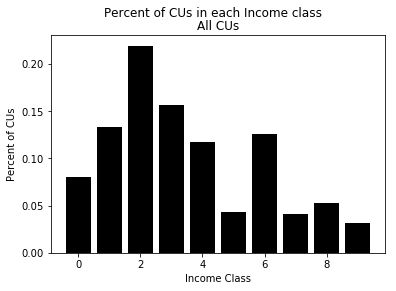

In [10]:
fmliTotalRecoded = binColumn(dataframe=fmli, toBinColumnName="FINCBTXM", binValues=incomeBrackets, binnedColumnName="INCLASS", labels=range(0,len(incomeBrackets)-1))

plt.bar(fmliTotalRecoded.INCLASS.value_counts().index, (fmliTotalRecoded.INCLASS.value_counts().values)/(len(fmliTotalRecoded)), color="black")
plt.suptitle("Percent of CUs in each Income class")
plt.title("All CUs")
plt.xlabel("Income Class")
plt.ylabel("Percent of CUs")
plt.show()

### Subsetting FMLI for age and recoding the incomebrackets

In [11]:
# subsetting for the age bracket
fmliAge = subsetDataframe(dataframe=fmli, columnName="AGE_REF", minValue=minAge, maxValue=maxAge)
fmliAge = fmliAge.reset_index()

# recoding the income brackets
fmliRecoded = binColumn(dataframe=fmliAge, toBinColumnName="FINCBTXM", binValues=incomeBrackets, binnedColumnName="INCLASS", labels=range(1,len(incomeBrackets)))

### Displaying the number of CUs where the reference person is retired

In [12]:
print("The percent of retired CUs is: "+str(round(len(fmliRecoded.INCNONW1.loc[fmliRecoded.INCNONW1 == 1])/len(fmliRecoded.INCNONW1),3)))

The percent of retired CUs is: 0.478


### Adding the Income class colum to the ExpensesByNewID dataframe

In [13]:
# combining the fmli and iExpensesByNewID
inclassExpenses = pd.merge(left=fmliRecoded[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])
# inclassExpenses

### Averaging the expenditures based on incomebrackets
inclassAverages is average money spent for each incomeclass

In [14]:
# getting mean for all columns with the same income class besides newId and creating new dataframe
inclassAverages = round(inclassExpenses.ix[: ,inclassExpenses.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# inclassAverages

### Converting the Average expenditures for income classes into percentages of expenditures
percentages is the percent of total expenditure for each category for each incomeclass 

In [15]:
# creating new dataframe for the percentages that only includes the plynty categories
percentages = inclassAverages.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    percentages[column] = inclassAverages[column]/inclassAverages.iTotalExp
percentages['ExpInc'] = inclassAverages['iTotalExp']/inclassAverages['FINCBTXM']

# truncate the max ExpInc
percentages.ExpInc.ix[percentages['ExpInc']>1] = 1

# percentages

# Exploring Issues in the data

### Getting Description of the inclassExpenses dataframe

In [16]:
# max and min of housing per income class
rowDescription = []
for inclass in range(1,len(incomeBrackets)):
    rowDescription.append(inclassExpenses.iHousing.loc[inclassExpenses.INCLASS == inclass].describe())
descriptions = pd.concat(rowDescription, axis=1)
descriptions.columns = range(0,len(incomeBrackets)-1)
descriptions = descriptions.transpose()
descriptions

,count,mean,std,min,25%,50%,75%,max
0,270.0,9673.507407,9635.872655,30.0,3001.5,6626.0,12224.50,51036.0
1,664.0,8615.402108,11913.176875,4.0,2969.0,5406.0,9891.00,181360.0
2,1449.0,10021.600414,10905.101171,-22664.0,3236.0,7224.0,12532.00,105052.0
3,1026.0,11659.121832,10299.216942,108.0,4621.0,9168.0,15486.00,94860.0
4,675.0,15275.733333,13203.818164,90.0,6930.0,12284.0,20150.00,146416.0
5,263.0,16770.471483,14208.363513,500.0,8388.0,13184.0,21494.00,107284.0
6,646.0,19896.789474,18711.166439,4.0,8661.0,15226.0,26113.75,170024.0
7,205.0,27140.726829,25022.454063,1920.0,13292.0,22872.0,31732.00,227912.0
8,275.0,32254.814545,46560.863337,1366.0,12258.0,24752.0,40234.50,700492.0
9,163.0,42345.693252,47280.665927,1820.0,16218.0,32484.0,49722.50,312149.0


### Removing outliers in iHousing
 - For each income class
    - Find Q1 and Q3
    - Calculate IQR
    - Find rows outside of Q3/Q2 +/- (1.5 x IQR) and Q3/Q2 +/- (3 x IQR)
 - Remove Rows from Dataframe
 - Clean1: Inner Fence
 - Clean2: Outer Fence

In [17]:
# cleaning the inclassExpenses dataframe of outliers
outliers1 = inclassExpenses.copy()


outliers1
innerFence = []
outerFence = []


print("There are "+str(len(inclassExpenses))+" rows before removal of outliers")

for inclass in range(1,len(incomeBrackets)):
    outliers1InClass = outliers1.where(outliers1['INCLASS']==inclass)
    Q1 = outliers1InClass['iHousing'].quantile(0.25)
    Q3 = outliers1InClass['iHousing'].quantile(0.75)
    IQR = Q3 - Q1
    innerFence.extend(outliers1InClass[outliers1InClass['iHousing'] < (Q1 - (1.5 * IQR))].index.tolist())
    innerFence.extend(outliers1InClass[outliers1InClass['iHousing'] > (Q3 + (1.5 * IQR))].index.tolist())    
    outerFence.extend(outliers1InClass[outliers1InClass['iHousing'] < (Q1 - (3 * IQR))].index.tolist())
    outerFence.extend(outliers1InClass[outliers1InClass['iHousing'] > (Q3 + (3 * IQR))].index.tolist())


clean1 = outliers1.drop(outliers1.index[innerFence])
clean1
clean2 = outliers1.drop(outliers1.index[outerFence])
clean2

print("Removed "+str(len(innerFence))+ " rows deemed to be out of inner fence")
print("Removed "+str(round(len(innerFence)/len(inclassExpenses)*100,2))+ "% of the CUs")

print("Removed "+str(len(outerFence))+ " rows deemed to be out of inner fence")
print("Removed "+str(round(len(outerFence)/len(inclassExpenses)*100,2))+ "% of the CUs")

# creating the descriptions for the cleaned outlier dataframe
rowDescription1 = []
for inclass in range(1,len(incomeBrackets)):
    rowDescription1.append(clean1.iHousing.loc[clean1.INCLASS == inclass].describe())
descriptions1 = pd.concat(rowDescription1, axis=1)
descriptions1.columns = range(0,len(incomeBrackets)-1)
descriptions1 = descriptions1.transpose()
# descriptions1

There are 5636 rows before removal of outliers
Removed 305 rows deemed to be out of inner fence
Removed 5.41% of the CUs
Removed 121 rows deemed to be out of inner fence
Removed 2.15% of the CUs


### Looking at the outliers that were removed

In [18]:
innerOutliers = inclassExpenses.copy()
innerOutliers = innerOutliers.ix[innerFence,:]
print("Number of outliers in each income class: "+str(innerOutliers.INCLASS.value_counts().values))
innerOutliers.head()

Number of outliers in each income class: [87 50 44 31 29 22 14 10 10  8]


,NEWID,INCLASS,FINCBTXM,iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple
607,3066713,1,7900.0,114605.6,5544.0,20448.0,27100.0,5420.0,4280.0,17788.0,5005.6,13860.0,360.0,14800.0,0.0,0.0,0.0
1240,3000783,1,2615.0,53130.8,5720.0,4040.0,29552.0,9656.0,960.0,5320.0,2618.8,6236.0,340.0,660.0,0.0,0.0,11972.0
1360,3057933,1,6155.0,101969.6,5436.0,4492.0,40720.0,6060.0,1640.0,18032.0,16593.6,6260.0,0.0,4800.0,0.0,0.0,2064.0
1818,3149211,1,3756.0,58845.6,11140.0,260.0,30524.0,5340.0,1788.0,4080.0,5801.6,2300.0,240.0,600.0,0.0,0.0,3228.0
1932,3170291,1,9310.0,67181.6,7520.0,1980.0,45476.0,5456.0,936.0,9916.0,5277.6,1428.0,0.0,3120.0,0.0,0.0,13928.0


In [19]:
outerOutliers = inclassExpenses.copy()
outerOutliers = outerOutliers.ix[outerFence,:]
print("Number of outliers in each income class: "+str(outerOutliers.INCLASS.value_counts().values))
outerOutliers.head()

Number of outliers in each income class: [36 26 13 10 10  7  6  5  5  3]


,NEWID,INCLASS,FINCBTXM,iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple
1360,3057933,1,6155.0,101969.6,5436.0,4492.0,40720.0,6060.0,1640.0,18032.0,16593.6,6260.0,0.0,4800.0,0.0,0.0,2064.0
1932,3170291,1,9310.0,67181.6,7520.0,1980.0,45476.0,5456.0,936.0,9916.0,5277.6,1428.0,0.0,3120.0,0.0,0.0,13928.0
2611,3105983,1,9906.0,75915.8,5880.0,5520.0,40649.0,3780.0,800.0,6076.0,9938.8,14188.0,0.0,0.0,0.0,0.0,10916.0
2717,3149212,1,3756.0,75077.6,12296.0,1480.0,40132.0,5480.0,2320.0,6276.0,5241.6,2444.0,1160.0,1540.0,0.0,0.0,3292.0
2822,3170292,1,9310.0,56593.6,8172.0,1668.0,40608.0,4056.0,340.0,4400.0,2877.6,1604.0,48.0,3120.0,0.0,0.0,10300.0


### Things learned from removing outliers
- Removing outliers helped some of the standard deviation crazyness
- Higher incomebrackets have greater standard deviation even without outliers

### Creating the percentage output for cleaned dataframe

In [20]:
# creating percentage outputs for cleaned dataframe
inclassCleanAverages1 = round(clean1.ix[: ,clean1.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentages1 = inclassCleanAverages1.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentages1[column] = inclassCleanAverages1[column]/inclassCleanAverages1.iTotalExp
cleanPercentages1['ExpInc'] = inclassCleanAverages1['iTotalExp']/inclassCleanAverages1['FINCBTXM']
# truncate the max ExpInc
cleanPercentages1.ExpInc.ix[cleanPercentages1['ExpInc']>1] = 1
cleanPercentages1

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.145309,0.070729,0.267548,0.102425,0.024094,0.145617,0.143997,0.046841,0.041591,0.032271,0.003797,0.001676,0.025896,1.000000
1,0.147200,0.063761,0.260450,0.120966,0.028186,0.161744,0.119256,0.056239,0.017617,0.038591,0.006002,0.002604,0.022615,1.000000
2,0.132833,0.065906,0.233812,0.103771,0.025187,0.182989,0.143245,0.060388,0.020654,0.045541,0.005739,0.003298,0.023364,1.000000
3,0.120112,0.063256,0.247408,0.098451,0.027001,0.193617,0.144102,0.056321,0.017486,0.053237,0.008585,0.004337,0.033914,0.833829
4,0.115424,0.061730,0.265221,0.089375,0.032807,0.195071,0.136493,0.055051,0.017505,0.051271,0.009013,0.004935,0.033896,0.715285
5,0.105811,0.053990,0.255489,0.083360,0.024646,0.257764,0.125818,0.054827,0.014239,0.042713,0.009674,0.008775,0.037107,0.680236
6,0.101092,0.066690,0.261519,0.080689,0.031306,0.216177,0.117293,0.072884,0.016905,0.066388,0.009784,0.007291,0.048020,0.607193
7,0.098440,0.052691,0.315706,0.082197,0.031819,0.207920,0.105127,0.065340,0.017535,0.050984,0.010179,0.017260,0.055199,0.492282
8,0.092483,0.069697,0.309592,0.069272,0.037903,0.169398,0.093660,0.070942,0.027825,0.073503,0.015652,0.019810,0.049738,0.449983
9,0.080749,0.067937,0.293107,0.057122,0.040568,0.228424,0.081494,0.063632,0.029704,0.065556,0.009256,0.019348,0.036896,0.366809


In [21]:
# creating percentage outputs for cleaned dataframe
inclassCleanAverages2 = round(clean2.ix[: ,clean2.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentages2 = inclassCleanAverages2.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentages2[column] = inclassCleanAverages2[column]/inclassCleanAverages2.iTotalExp
cleanPercentages2['ExpInc'] = inclassCleanAverages2['iTotalExp']/inclassCleanAverages2['FINCBTXM']
# truncate the max ExpInc
cleanPercentages2nonTruncated = cleanPercentages2.copy()
cleanPercentages2.ExpInc.ix[cleanPercentages2['ExpInc']>1] = 1
cleanPercentages2

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.138705,0.072955,0.291189,0.099581,0.025477,0.140606,0.139695,0.051854,0.036794,0.031098,0.004037,0.001808,0.033799,1.000000
1,0.142165,0.062307,0.276651,0.118244,0.027864,0.158800,0.120681,0.055173,0.016945,0.040694,0.006466,0.003126,0.029117,1.000000
2,0.128612,0.064890,0.246419,0.100264,0.025571,0.179751,0.141492,0.063465,0.019580,0.048232,0.005508,0.003246,0.027029,1.000000
3,0.116798,0.063737,0.258419,0.095086,0.028973,0.195366,0.139126,0.056337,0.016735,0.051907,0.008169,0.004046,0.034698,0.870509
4,0.112842,0.061638,0.278891,0.087546,0.031975,0.192668,0.133651,0.053744,0.016851,0.050210,0.009034,0.004657,0.033708,0.734786
5,0.105645,0.053777,0.261191,0.082415,0.024242,0.259005,0.123794,0.054287,0.014699,0.042134,0.009444,0.008610,0.039242,0.686132
6,0.099949,0.066432,0.273018,0.079546,0.031145,0.211418,0.115305,0.072266,0.016753,0.067029,0.009443,0.006981,0.049286,0.618234
7,0.097544,0.058423,0.333984,0.080075,0.037729,0.199712,0.099335,0.063545,0.016271,0.047911,0.009625,0.016012,0.060165,0.509558
8,0.089820,0.069820,0.322736,0.068060,0.036794,0.171376,0.092578,0.069909,0.026871,0.072209,0.016398,0.020367,0.056938,0.458924
9,0.080087,0.067625,0.303353,0.056593,0.040234,0.223652,0.080277,0.063015,0.033355,0.063590,0.009112,0.018767,0.039661,0.369520


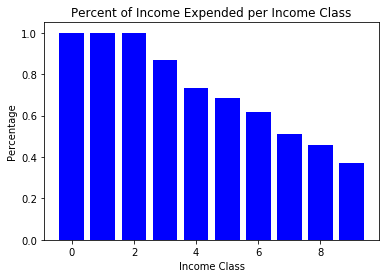

In [22]:
plt.bar(cleanPercentages2.index, cleanPercentages2.ExpInc, color = 'b')
plt.title("Percent of Income Expended per Income Class")
plt.xlabel("Income Class")
plt.ylabel("Percentage")
plt.show()

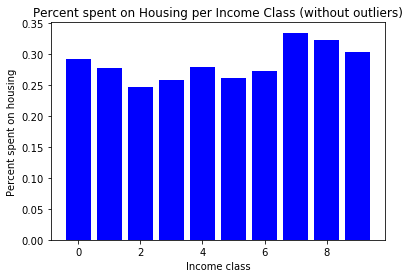

In [23]:
plt.bar(cleanPercentages2.index, cleanPercentages2.iHousing, color = 'b')
plt.title("Percent spent on Housing per Income Class (without outliers)")
plt.xlabel("Income class")
plt.ylabel("Percent spent on housing")
plt.show()

# Plots

In [24]:
# ploting the number of people in each bracket
print(inclassExpenses.INCLASS.value_counts().values)
plt.bar(list(inclassExpenses.INCLASS.value_counts().index.tolist()), inclassExpenses.INCLASS.value_counts().values, align='center', color = "r")
plt.title("Number of CUs in Income classes (with outliers)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[1449 1026  675  664  646  275  270  263  205  163]


In [25]:
# creating the plot of percent of income expended per income class
plt.bar(percentages.index, percentages.ExpInc, color = 'r')
plt.title("Percent of Income Expended per Income Class (with outliers)")
plt.xlabel("Income Class")
plt.ylabel("Percentage")
# plt.show()

In [26]:
# creating plot of Percent spent on Housing per income class
plt.bar(percentages.index, percentages.iHousing, color = 'r')
plt.ylim(0,.4)
plt.title("Percent spent on Housing per Income Class (with outliers)")
plt.xlabel("Income class")
plt.ylabel("Percent spent on housing")
# plt.show()

In [27]:
inclassSD = inclassExpenses.groupby(['INCLASS'],as_index=False).std()
inclassSD.iHousing
plt.bar(inclassSD.iHousing.index, inclassSD.iHousing, color = 'r')
plt.title("Standard deviations in Income Classes (with outliers)")
plt.ylim(0,60000)
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

In [28]:
# ploting the number of people in each bracket
print(clean1.INCLASS.value_counts().values)
plt.bar(list(clean1.INCLASS.value_counts().index.tolist()), clean1.INCLASS.value_counts().values, align='center', color="g")
plt.title("Number of CUs in Income classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[1362  982  644  617  614  265  253  248  191  155]


In [29]:
inclassClean1SD = clean1.groupby(['INCLASS'],as_index=False).std()
inclassClean1SD.iHousing
plt.bar(inclassClean1SD.iHousing.index, inclassClean1SD.iHousing,color = 'g')
plt.ylim(0,60000)
plt.title("Standard deviations in Income Classes (inner fence)")
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

In [30]:
# ploting the number of people in each bracket
print(clean2.INCLASS.value_counts().values)
plt.bar(list(clean2.INCLASS.value_counts().index.tolist()), clean2.INCLASS.value_counts().values, align='center', color="b")
plt.title("Number of CUs in Income classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[1413 1016  665  638  633  272  263  257  200  158]


In [31]:
inclassClean2SD = clean2.groupby(['INCLASS'],as_index=False).std()
inclassClean2SD.iHousing
plt.bar(inclassClean2SD.iHousing.index, inclassClean2SD.iHousing,color = 'b')
plt.ylim(0,60000)
plt.title("Standard deviations in Income Classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

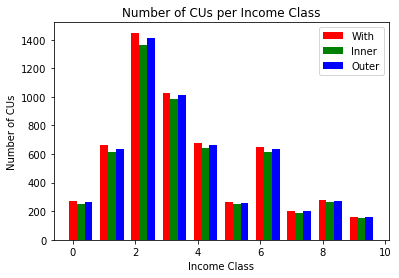

array([1413, 1016,  665,  638,  633,  272,  263,  257,  200,  158])

In [32]:
plt.close()
n_groups = 4
values1 = inclassExpenses.INCLASS.value_counts().values
values2 = clean1.INCLASS.value_counts().values
values3 = clean2.INCLASS.value_counts().values

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(inclassExpenses.INCLASS.value_counts().index -1, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(clean1.INCLASS.value_counts().index -1 + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(clean2.INCLASS.value_counts().index - 1 + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Number of CUs')
plt.title('Number of CUs per Income Class')
plt.legend()
plt.show()
clean2.INCLASS.value_counts().values

The average percent change between with and without outliers: 2.05%


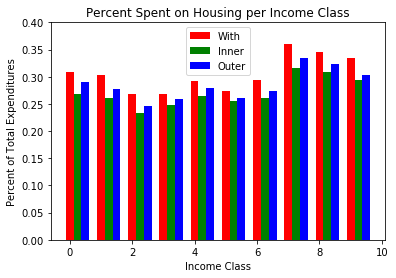

In [33]:
n_groups = 4
values1 = percentages.iHousing
values2 = cleanPercentages1.iHousing
values3 = cleanPercentages2.iHousing

print("The average percent change between with and without outliers: "+str(round((values1-values3).mean()*100,2))+"%")

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Housing per Income Class')
plt.ylim(0,.4)
plt.legend()
plt.show()

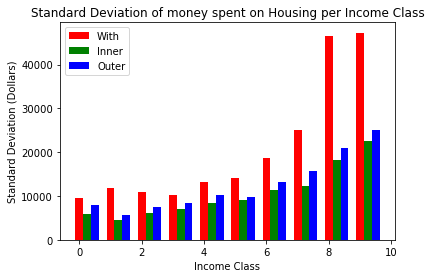

In [34]:
n_groups = 4
values1 = inclassSD.iHousing
values2 = inclassClean1SD.iHousing
values3 = inclassClean2SD.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Standard Deviation (Dollars)')
plt.title('Standard Deviation of money spent on Housing per Income Class')
plt.legend()
plt.show()

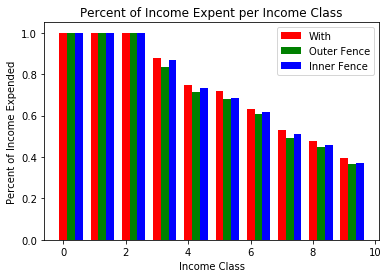

In [35]:
n_groups = 3
values1 = percentages.ExpInc
values2 = cleanPercentages1.ExpInc
values3 = cleanPercentages2.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Outer Fence')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Inner Fence')
 
plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

# Least squares polynomial fit
any value that would cause a person to expend over 100% of their income is truncated to 100%

          3             2
7.96e-13 x - 7.337e-07 x + 0.4607 x + 2.221e+04


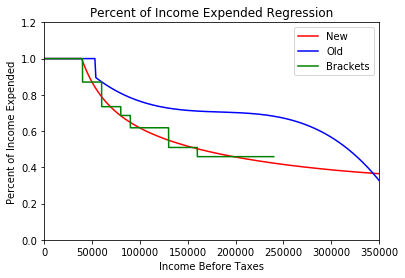

In [36]:
# cleanPercentages2.ExpInc[3:]
cleanReg = clean2[["FINCBTXM","iTotalExp"]]
cleanReg = cleanReg.loc[clean2.FINCBTXM > 0]
cleanReg = cleanReg.loc[cleanReg.iTotalExp > 0]
cleanReg
def getExpendPercent(income):
    if income <= 0:
        return(1)
    coefficients = np.polyfit(cleanReg.FINCBTXM, cleanReg.iTotalExp, deg = 3)
    p = np.poly1d(coefficients)
    np.seterr(divide='ignore')
    percent = p(income)/income
    if percent > 1:
        percent = 1
    return(percent)

def printRegression():
    coefficients = np.polyfit(cleanReg.FINCBTXM, cleanReg.iTotalExp, deg = 3)
    p = np.poly1d(coefficients)
    print(p)
    
    
printRegression()
    
x = range(0,360000,1000)
x2 = range(0,360000,1000)
y =[]
y2 =[]
def oldRegression(income):
    if income > 53000:
        output = ((-7.6108*(10**(-17)))*(income**3))+((4.2009*(10**(-11)))*(income**2))+((-7.90256*(10**-6))*income)+1.21112
    else:
        output = 1
    return(output)


for bracket in range(0,360000,1000):
    y.append(getExpendPercent(bracket))
    y2.append(oldRegression(bracket))
# plt.plot(inclassCleanAverages2.FINCBTXM,cleanPercentages2.ExpInc)
plt.plot(x,y, color = "r", label="New")
plt.plot(x2,y2, color = "b", label = "Old")
x3 = range(0,incomeBrackets[len(incomeBrackets)-2])

# creating the repeatArray for income Bracket plotting
lastvalue = 0
repeatArray = []
for x in range(0,len(incomeBrackets[1:len(incomeBrackets)-1])):
    repeatArray.append(incomeBrackets[1:len(incomeBrackets)-1][x] - lastvalue)
    lastvalue = incomeBrackets[1:len(incomeBrackets)-1][x]

y3 = np.repeat(cleanPercentages2.ExpInc[0:len(cleanPercentages2)-1], repeatArray)
plt.plot(x3,y3, color = "g", label = "Brackets")
plt.title("Percent of Income Expended Regression")
plt.xlabel("Income Before Taxes")
plt.ylabel("Percent of Income Expended")
plt.xlim(0,350000)
plt.ylim(0,1.2)
plt.legend()
plt.show()

### Plot of number of CUs for clean2 only

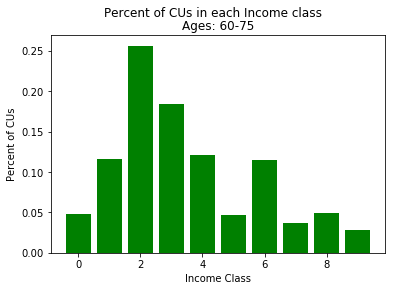

In [37]:
plt.bar(clean2.INCLASS.value_counts().index - 1, (clean2.INCLASS.value_counts().values)/(len(clean2)), alpha=opacity, color='g')
plt.suptitle("Percent of CUs in each Income class")
plt.title("Ages: 60-75")
plt.xlabel("Income Class")
plt.ylabel("Percent of CUs")
plt.show()

# Examples of Users

In [38]:
usersIncome = [30000, 60000, 90000, 120000, 250000]
def getIncomeBracket(income):
    for bracket in range(len(incomeBrackets)-2,0,-1):
        if income > incomeBrackets[bracket]:
            return bracket
            

exampleExpenses = pd.DataFrame(columns = cleanPercentages2.columns, index = range(len(usersIncome)))
for user in usersIncome:
    userBracket = getIncomeBracket(user)
    userExpendAmount = getExpendPercent(user) * user
    userBaseExpenses = (cleanPercentages2.loc[userBracket]*userExpendAmount)/12
    exampleExpenses.loc[usersIncome.index(user)] = userBaseExpenses

exampleExpenses.index = usersIncome

exampleExpenses

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
30000,321.531,162.224,616.049,250.659,63.9275,449.377,353.73,158.662,48.9505,120.579,13.7689,8.11414,67.5724,2500
60000,461.177,251.667,1020.37,375.447,114.398,771.403,549.34,222.449,66.0769,204.953,32.2541,15.9771,137.007,3437.21
90000,513.332,261.304,1269.14,400.455,117.792,1258.51,601.519,263.781,71.4252,204.733,45.8871,41.8368,190.677,3333.95
120000,568.884,378.117,1553.95,452.755,177.269,1203.34,656.29,411.319,95.3554,381.511,53.7495,39.7368,280.524,3518.83
250000,693.8,585.842,2627.96,490.272,348.548,1937.5,695.446,545.903,288.956,550.881,78.9352,162.584,343.587,3201.17


# Creating CSV fo percentages

In [39]:
# cleanPercentages2.to_csv("percentage60to75.csv")

# Importing CSVs of pre-Subset Percentages CSVs

In [40]:
ageRange1 = pd.read_csv("percentage55to64.csv", index_col=0)
ageRange2 = pd.read_csv("percentage60to75.csv", index_col=0)
ageRange3 = pd.read_csv("percentage65up.csv", index_col=0)

### Plotting the differences between Age brackets

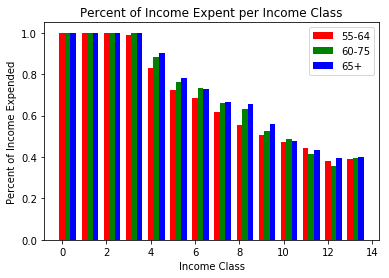

In [41]:
n_groups = 3
values1 = ageRange1.ExpInc
values2 = ageRange2.ExpInc
values3 = ageRange3.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60-75')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

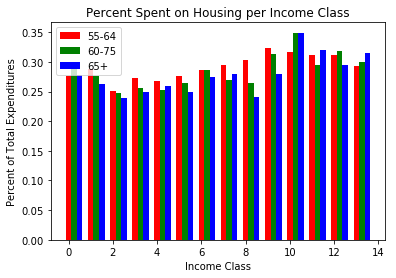

In [42]:
n_groups = 3
values1 = ageRange1.iHousing
values2 = ageRange2.iHousing
values3 = ageRange3.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60-75')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Housing per Income Class')
plt.legend()
plt.show()

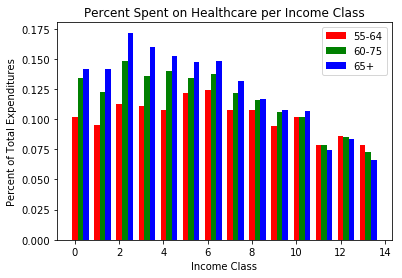

In [43]:
n_groups = 3
values1 = ageRange1.iHealthcare
values2 = ageRange2.iHealthcare
values3 = ageRange3.iHealthcare

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60-75')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Healthcare per Income Class')
plt.legend()
plt.show()

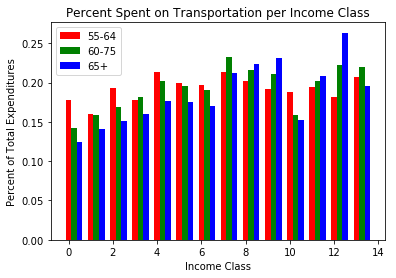

In [44]:
n_groups = 2
values1 = ageRange1.iTransportation
values2 = ageRange2.iTransportation
values3 = ageRange3.iTransportation

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60-75')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Transportation per Income Class')
plt.legend()
plt.show()

# Thoughts on the difference between 55-64, 60-75, and 65+
- On average: 55-64 < 60-75 < 65+ in terms of expenditure percentage
- This could be because the people in the 60-75 and 65+ bracket are actually retired meaning their income is lower?
 - will check this

## What each bracket might represent
- 55-64 simulates that specific time right before and right at the begining of retirment
- 60-75 simulates the time during retirement with some non-retired CUs
- 65+ is a higher potential to show people who have actually retired